In [1]:
import tensorflow as tf
from tensorflow import keras 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from datetime import datetime

In [2]:
# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
df = pd.read_csv("merged_macro_commodity.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 7 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   date                                           408 non-null    object 
 1   Revenue, excluding grants (% of GDP)           408 non-null    float64
 2   GDP (constant 2015 US$)                        408 non-null    float64
 3   Employment to population ratio (15+, total %)  408 non-null    float64
 4   Crude Oil Brent Price                          408 non-null    float64
 5   Cocoa Price                                    408 non-null    float64
 6   Gold Price                                     408 non-null    float64
dtypes: float64(6), object(1)
memory usage: 22.4+ KB


In [4]:
data = df.copy()
data['date'] = pd.to_datetime(data['date'])

In [5]:
import plotly.express as px
import plotly.graph_objects as go


def plotting(title, data, x, y, x_label, y_label, text=False, lam=None):
    """General function to plot the data."""
    fig = px.line(data, x=data[x], y=data[y], labels={x: x_label, y: y_label})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title, width=650, title_x=0.5, height=400)
    if text:
      fig.add_annotation(
          x='1952-12-20', y=10, text=f'Lambda = {lam:.3f}',
          align='left', yanchor='bottom', showarrow=False,
          font=dict(size=20, color="black", family="Courier New, monospace"),
          bordercolor='black', borderwidth=2, bgcolor="white"
      )
    fig.show()


def add_separator(width=650):
    """Add a horizontal line as a separator."""
    fig = go.Figure()
    fig.add_hline(y=0.5, line_dash="dot", line_color="gray", line_width=2)
    fig.update_layout(height=50, width=width, margin=dict(l=20, r=20, t=20, b=20), xaxis_visible=False, yaxis_visible=False)
    fig.show()


In [6]:
plotting(title='Revenue Over Time', data=data, x='date', y='Revenue, excluding grants (% of GDP)', x_label='Date', y_label='%')

In [7]:
len(data)

408

In [8]:
# Add volatility as an additional target
df['CrudeOil_Volatility'] = df['Crude Oil Brent Price'].pct_change().rolling(12).std()
df['Cocoa_Volatility'] = df['Cocoa Price'].pct_change().rolling(12).std()
df['Gold_Volatility'] = df['Gold Price'].pct_change().rolling(12).std()

In [9]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Prepare volatility features
for commodity in ['Crude Oil Brent Price', 'Cocoa Price', 'Gold Price']:
    df[f'{commodity.split()[0]}_Volatility'] = df[commodity].pct_change().rolling(12).std()

# Define features and targets
features = [
    'Revenue, excluding grants (% of GDP)', 
    'GDP (constant 2015 US$)', 
    'Employment to population ratio (15+, total %)',
    'CrudeOil_Volatility',
    'Cocoa_Volatility',
    'Gold_Volatility'
]
targets = ['Crude Oil Brent Price', 'Cocoa Price', 'Gold Price']

# Handle missing values from volatility calculation
df = df.dropna()

# Scale features and targets separately
feature_scaler = RobustScaler()
target_scaler = RobustScaler()

X_scaled = feature_scaler.fit_transform(df[features])
y_scaled = target_scaler.fit_transform(df[targets])

# Create sequences with 12-month lookback
def create_sequences(X, y, n_steps):
    X_seq, y_seq = [], []
    for i in range(n_steps, len(X)):
        X_seq.append(X[i-n_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

n_steps = 12
X_seq, y_seq = create_sequences(X_scaled, y_scaled, n_steps)

# Build enhanced LSTM model with volatility awareness
model = Sequential([
    # First LSTM layer with attention to volatility
    LSTM(256, activation='tanh', 
         input_shape=(n_steps, len(features)),
         kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),
         return_sequences=True),
    BatchNormalization(),
    Dropout(0.25),
    
    # Second LSTM layer
    LSTM(128, activation='tanh',
         kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.25),
    
    # Volatility-conditioned dense layers
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    
    # Final output layer
    Dense(len(targets))
])

# Custom learning rate with decay
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train with temporal cross-validation
test_size = int(0.2 * len(X_seq))
X_train, X_test = X_seq[:-test_size], X_seq[-test_size:]
y_train, y_test = y_seq[:-test_size], y_seq[-test_size:]

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, lr_scheduler],
    verbose=0
)

# Evaluate with walk-forward validation
def evaluate_walk_forward(X, y, model, steps):
    predictions = []
    actuals = []
    for i in range(steps):
        x_input = X[-(steps-i)].reshape(1, n_steps, X.shape[2])
        y_pred = model.predict(x_input, verbose=0)
        predictions.append(y_pred[0])
        actuals.append(y[-(steps-i)])
    return np.array(predictions), np.array(actuals)

preds, actuals = evaluate_walk_forward(X_seq, y_seq, model, test_size)
preds = target_scaler.inverse_transform(preds)
actuals = target_scaler.inverse_transform(actuals)

# Commodity-specific evaluation
results = {}
for i, target in enumerate(targets):
    mape = mean_absolute_percentage_error(actuals[:, i], preds[:, i])
    rmse = root_mean_squared_error(actuals[:, i], preds[:, i])
    results[target] = {'MAPE': mape*100, 'RMSE': rmse}
    print(f"{target.upper():<25} MAPE: {mape*100:.2f}% | RMSE: {rmse:.2f}")

# Feature importance analysis (permutation importance)
def calculate_permutation_importance(model, X_test, y_test, n_iterations=10):
    baseline = model.evaluate(X_test, y_test, verbose=0)[0]
    importance = {i: 0 for i in range(len(features))}
    
    for i in range(len(features)):
        X_temp = X_test.copy()
        for _ in range(n_iterations):
            X_temp[:, :, i] = np.random.permutation(X_temp[:, :, i])
            loss = model.evaluate(X_temp, y_test, verbose=0)[0]
            importance[i] += (loss - baseline)/n_iterations
            
    return {features[k]: v for k, v in importance.items()}

perm_importance = calculate_permutation_importance(model, X_test, y_test)
print("\nFeature Importance:")
for feat, imp in sorted(perm_importance.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feat:<35} {imp:.4f}")

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



CRUDE OIL BRENT PRICE     MAPE: 32.60% | RMSE: 22.69
COCOA PRICE               MAPE: 21.48% | RMSE: 2.03
GOLD PRICE                MAPE: 34.57% | RMSE: 754.39

Feature Importance:
Cocoa_Volatility                    -0.1038
CrudeOil_Volatility                 0.0405
Revenue, excluding grants (% of GDP) 0.0210
GDP (constant 2015 US$)             0.0138
Employment to population ratio (15+, total %) 0.0124
Gold_Volatility                     -0.0088


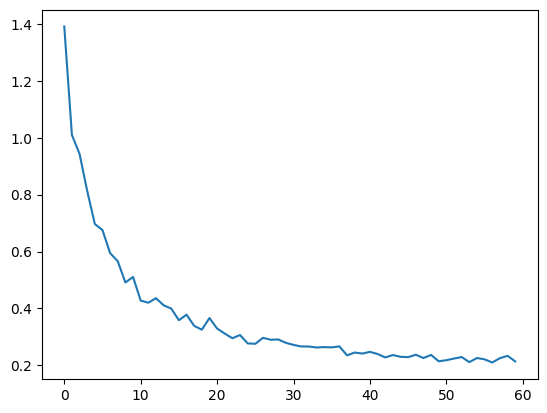

In [10]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)